<a href="https://colab.research.google.com/github/Vaish203-Desai/Customer-Churn-Prediction/blob/main/Scorecard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_csv('/content/credit_score.csv')


In [ ]:
df

,CUST_ID,INCOME,SAVINGS,DEBT,R_SAVINGS_INCOME,R_DEBT_INCOME,R_DEBT_SAVINGS,T_CLOTHING_12,T_CLOTHING_6,R_CLOTHING,...,R_EXPENDITURE_SAVINGS,R_EXPENDITURE_DEBT,CAT_GAMBLING,CAT_DEBT,CAT_CREDIT_CARD,CAT_MORTGAGE,CAT_SAVINGS_ACCOUNT,CAT_DEPENDENTS,CREDIT_SCORE,DEFAULT
0,C02COQEVYU,33269,0,532304,0.0000,16.0000,1.2000,1889,945,0.5003,...,0.0000,0.0625,High,1,0,0,0,0,444,1
1,C02OZKC0ZF,77158,91187,315648,1.1818,4.0909,3.4615,5818,111,0.0191,...,0.7692,0.2222,No,1,0,0,1,0,625,0
2,C03FHP2D0A,30917,21642,534864,0.7000,17.3000,24.7142,1157,860,0.7433,...,1.4286,0.0578,High,1,0,0,1,0,469,1
3,C03PVPPHOY,80657,64526,629125,0.8000,7.8000,9.7499,6857,3686,0.5376,...,1.2500,0.1282,High,1,0,0,1,0,559,0
4,C04J69MUX0,149971,1172498,2399531,7.8182,16.0000,2.0465,1978,322,0.1628,...,0.1163,0.0568,High,1,1,1,1,1,473,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,CZQHJC9HDH,328892,1465066,5501471,4.4546,16.7273,3.7551,16701,10132,0.6067,...,0.2041,0.0543,High,1,1,1,1,1,418,0
996,CZRA4MLB0P,81404,88805,680837,1.0909,8.3637,7.6667,5400,1936,0.3585,...,0.8333,0.1087,No,1,0,0,1,0,589,1
997,CZSOD1KVFX,0,42428,30760,3.2379,8.1889,0.7250,0,0,0.8779,...,0.2500,0.3448,No,1,0,0,1,0,499,0
998,CZWC76UAUT,36011,8002,604181,0.2222,16.7777,75.5037,1993,1271,0.6377,...,5.0002,0.0662,No,1,1,0,1,0,507,0


In [ ]:
df.isnull().sum()

,0
CUST_ID,0
INCOME,0
SAVINGS,0
DEBT,0
R_SAVINGS_INCOME,0
...,...
CAT_MORTGAGE,0
CAT_SAVINGS_ACCOUNT,0
CAT_DEPENDENTS,0
CREDIT_SCORE,0


In [ ]:
duplicate_ids = df[df['CUST_ID'].duplicated()]
print("Number of duplicate CUST_IDs:", duplicate_ids.shape[0])

Number of duplicate CUST_IDs: 0


In [ ]:
target = 'DEFAULT'

In [ ]:
# Drop non-predictive columns
ignore_cols = ['CUST_ID', 'CREDIT_SCORE', target]
features = [col for col in df.columns if col not in ignore_cols]


In [ ]:
# Function to calculate WOE & IV for a single feature
def calc_iv_woe(data, feature, target):
    df_temp = pd.DataFrame()
    df_temp['feature'] = data[feature]
    df_temp['target'] = data[target]

      # Handle missing values by filling them with a special category
    df_temp['feature'] = df_temp['feature'].fillna("MISSING")

    # Create groups for numerical features (binning)
    if pd.api.types.is_numeric_dtype(df_temp['feature']):
        df_temp['feature'] = pd.qcut(df_temp['feature'], q=10, duplicates="drop")

    grouped = df_temp.groupby('feature')
    stats = pd.DataFrame()
    stats['good'] = grouped['target'].apply(lambda x: (x == 0).sum())
    stats['bad'] = grouped['target'].apply(lambda x: (x == 1).sum())

    stats['dist_good'] = stats['good'] / stats['good'].sum()
    stats['dist_bad'] = stats['bad'] / stats['bad'].sum()

    # Replace 0 to avoid division by zero / log issues
    stats['dist_good'] = stats['dist_good'].replace(0, 0.0001)
    stats['dist_bad'] = stats['dist_bad'].replace(0, 0.0001)

    stats['woe'] = np.log(stats['dist_good'] / stats['dist_bad'])
    stats['iv'] = (stats['dist_good'] - stats['dist_bad']) * stats['woe']

    iv = stats['iv'].sum()
    return iv

# Calculate IV for all features
iv_values = {}
for feature in features:
    try:
        iv = calc_iv_woe(df, feature, target)
        iv_values[feature] = iv
    except Exception as e:
        print(f"Could not calculate IV for {feature}: {e}")

# Sort features by IV
iv_sorted = sorted(iv_values.items(), key=lambda x: x[1], reverse=True)

# Display results
iv_df = pd.DataFrame(iv_sorted, columns=['Feature', 'IV'])
print(iv_df)

# Save to CSV (optional)
iv_df.to_csv("feature_iv_values.csv", index=False)


/tmp/ipython-input-110426242.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby('feature')
/tmp/ipython-input-110426242.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby('feature')
/tmp/ipython-input-110426242.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby('feature')
/tmp/ipython-input-110426242.py:14: FutureWarning: The default of o

                 Feature        IV
0          R_DEBT_INCOME  0.362138
1             R_TAX_DEBT  0.342239
2     R_EXPENDITURE_DEBT  0.323180
3   R_ENTERTAINMENT_DEBT  0.289722
4          R_HEALTH_DEBT  0.277846
..                   ...       ...
79              CAT_DEBT  0.000000
80       CAT_CREDIT_CARD  0.000000
81          CAT_MORTGAGE  0.000000
82   CAT_SAVINGS_ACCOUNT  0.000000
83        CAT_DEPENDENTS  0.000000

[84 rows x 2 columns]


/tmp/ipython-input-110426242.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby('feature')
/tmp/ipython-input-110426242.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby('feature')
/tmp/ipython-input-110426242.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby('feature')
/tmp/ipython-input-110426242.py:14: FutureWarning: The default of o

In [ ]:
def calc_woe_iv(feature, target):
    df_temp = pd.DataFrame({"feature": feature, "target": target})

    # Bin numerical features into 10 bins
    if pd.api.types.is_numeric_dtype(feature):
        df_temp["bin"] = pd.qcut(feature.rank(method="first"), 10, duplicates="drop")
    else:
        df_temp["bin"] = feature

    grouped = df_temp.groupby("bin")

    stats = pd.DataFrame()
    stats["good"] = grouped["target"].apply(lambda x: (x==0).sum())
    stats["bad"] = grouped["target"].apply(lambda x: (x==1).sum())

    stats = stats[(stats["good"] > 0) | (stats["bad"] > 0)]
    stats["dist_good"] = stats["good"] / stats["good"].sum()
    stats["dist_bad"] = stats["bad"] / stats["bad"].sum()

    stats["woe"] = np.log((stats["dist_good"] + 1e-10) / (stats["dist_bad"] + 1e-10))
    stats["iv"] = (stats["dist_good"] - stats["dist_bad"]) * stats["woe"]

    return stats["iv"].sum()

# --- Step 2: Calculate IV for all features ---
excluded_cols = ["CUST_ID", "CREDIT_SCORE", "DEFAULT"]
iv_values = {}

for col in df.columns:
    if col not in excluded_cols:
        try:
            iv = calc_woe_iv(df[col], df["DEFAULT"])
            iv_values[col] = iv
        except:
            iv_values[col] = np.nan

iv_sorted = pd.Series(iv_values).sort_values(ascending=False)

# --- Step 3: Get Top 20 features ---
top20 = iv_sorted.head(20)   # <-- FIX: use head() on Series, not list
top_features = top20.index.tolist()
print("Top 20 Features:", top_features)

# --- Step 4: Extract rows with only top 20 features + target ---
df_top20 = df[top_features + ["DEFAULT"]]

output_path = "top20_features.csv"   # Save in current directory
df_top20.to_csv(output_path, index=False)

print("✅ File saved as:", output_path)

/tmp/ipython-input-102135345.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby("bin")
/tmp/ipython-input-102135345.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby("bin")
/tmp/ipython-input-102135345.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby("bin")
/tmp/ipython-input-102135345.py:10: FutureWarning: The default of observed=Fals

Top 20 Features: ['R_DEBT_INCOME', 'R_TAX_DEBT', 'R_EXPENDITURE_DEBT', 'R_ENTERTAINMENT_DEBT', 'R_HEALTH_DEBT', 'R_TRAVEL_DEBT', 'R_CLOTHING_DEBT', 'T_UTILITIES_12', 'R_DEBT_SAVINGS', 'T_UTILITIES_6', 'R_UTILITIES_DEBT', 'R_GROCERIES_DEBT', 'R_TAX_SAVINGS', 'T_TAX_6', 'T_TAX_12', 'T_GAMBLING_6', 'T_HOUSING_6', 'T_HOUSING_12', 'R_GAMBLING_DEBT', 'T_HEALTH_6']
✅ File saved as: top20_features.csv


In [ ]:
def calculate_vif(df, features):
   X = df[features].copy()

    # Add constant column for intercept
   X_const = add_constant(X)

   vif_data = pd.DataFrame()
   vif_data["Feature"] = X_const.columns
   vif_data["VIF"] = [variance_inflation_factor(X_const.values, i)
                       for i in range(X_const.shape[1])]

    # Drop the constant row
   return vif_data[vif_data["Feature"] != "const"].sort_values(by="VIF", ascending=False)

In [ ]:
vif_result = calculate_vif(df, top_features)
print(vif_result)

                 Feature           VIF
18          T_HOUSING_12  8.286422e+08
17           T_HOUSING_6  8.286419e+08
10         T_UTILITIES_6  5.128029e+04
8         T_UTILITIES_12  5.125961e+04
15              T_TAX_12  1.239911e+02
14               T_TAX_6  1.186048e+02
11      R_UTILITIES_DEBT  1.857606e+01
3     R_EXPENDITURE_DEBT  1.608925e+01
12      R_GROCERIES_DEBT  1.444169e+01
4   R_ENTERTAINMENT_DEBT  8.584791e+00
5          R_HEALTH_DEBT  8.081109e+00
7        R_CLOTHING_DEBT  6.141909e+00
2             R_TAX_DEBT  5.311334e+00
6          R_TRAVEL_DEBT  4.153606e+00
20            T_HEALTH_6  1.752098e+00
1          R_DEBT_INCOME  1.746486e+00
9         R_DEBT_SAVINGS  1.558759e+00
16          T_GAMBLING_6  1.492210e+00
19       R_GAMBLING_DEBT  1.446222e+00
13         R_TAX_SAVINGS  1.282168e+00


In [ ]:
# --- Step 1: Drop collinear features ---
drop_cols = ["T_HOUSING_6", "T_HOUSING_12", "T_UTILITIES_6", "T_UTILITIES_12"]

# Keep only T_TAX_6 (drop T_TAX_12)
drop_cols.append("T_TAX_12")

# Filter IV series again, excluding dropped features
iv_filtered = iv_sorted.drop(labels=drop_cols, errors="ignore")

# --- Step 2: Pick Top 10 Features ---
top10 = iv_filtered.head(10)
top10_features = top10.index.tolist()
print("✅ Final Top 10 Features:", top10_features)

# --- Step 3: Create dataset with top 10 + target ---
df_top10 = df[top10_features + ["DEFAULT"]]

# --- Step 4: Save to CSV ---
output_path = "top10_features.csv"   # saves in current working directory
df_top10.to_csv(output_path, index=False)

print("✅ File saved as:", output_path)


✅ Final Top 10 Features: ['R_DEBT_INCOME', 'R_TAX_DEBT', 'R_EXPENDITURE_DEBT', 'R_ENTERTAINMENT_DEBT', 'R_HEALTH_DEBT', 'R_TRAVEL_DEBT', 'R_CLOTHING_DEBT', 'R_DEBT_SAVINGS', 'R_UTILITIES_DEBT', 'R_GROCERIES_DEBT']
✅ File saved as: top10_features.csv


In [ ]:
df = pd.read_csv("/content/WOE_transformed.csv")


In [ ]:
df

,R_DEBT_INCOME,R_TAX_DEBT,R_ENTERTAINMENT_DEBT,R_HEALTH_DEBT,R_TRAVEL_DEBT,R_CLOTHING_DEBT,R_DEBT_SAVINGS,DEFAULT
0,-0.894553,-0.714985,-0.683544,-0.668410,-0.053483,-0.246597,0.525304,1
1,0.044695,-0.155186,0.200754,-0.668410,-0.053483,0.334530,-0.170934,0
2,-0.894553,-0.714985,-0.683544,-0.668410,-0.294659,-0.736964,-0.498363,1
3,-0.070291,-0.246374,0.255584,-0.046416,-0.053483,0.305584,-0.498363,0
4,-0.894553,-0.714985,-0.683544,-0.046416,-0.294659,-0.736964,-0.077408,0
...,...,...,...,...,...,...,...,...
995,-0.894553,-0.714985,-0.683544,-0.668410,-0.294659,-0.736964,-0.170934,0
996,-0.070291,-0.246374,0.200754,-0.668410,-0.053483,0.305584,-0.498363,1
997,-0.070291,-0.714985,-0.683544,-0.046416,0.461588,-0.736964,0.525304,0
998,-0.894553,-0.714985,-0.683544,-0.668410,-0.294659,-0.246597,-0.498363,0


In [ ]:
final_features = [
    "R_DEBT_INCOME",
    "R_TAX_DEBT",
    "R_ENTERTAINMENT_DEBT",
    "R_HEALTH_DEBT",
    "R_TRAVEL_DEBT",
    "R_CLOTHING_DEBT",
    "R_DEBT_SAVINGS"
]

X = df[final_features]
y = df["DEFAULT"]

# Train-test split (70-30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
# Logistic Regression model
model_balanced = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced')
model_balanced.fit(X_train, y_train)


# Predictions
y_pred_bal = model_balanced.predict(X_test)
y_prob_bal = model_balanced.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
import matplotlib.pyplot as plt

In [ ]:
#Confusion Matrix
cm_bal = confusion_matrix(y_test, y_pred_bal)
print("Confusion Matrix:\n", cm_bal)

Confusion Matrix:
 [[132  83]
 [ 28  57]]


Model is good at detecting non-defaulters (class 0) but weak at catching defaulters (class 1).

In [ ]:
#  Classification Report (precision, recall, f1-score)
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal))



Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.61      0.70       215
           1       0.41      0.67      0.51        85

    accuracy                           0.63       300
   macro avg       0.62      0.64      0.61       300
weighted avg       0.71      0.63      0.65       300



In [ ]:
#Accuracy
print("\nAccuracy:", accuracy_score(y_test, y_pred_bal))


Accuracy: 0.63


In [ ]:
# ROC-AUC Score
auc_bal = roc_auc_score(y_test, y_prob_bal)
print("\nROC-AUC Score:", auc_bal)



ROC-AUC Score: 0.6776196990424076


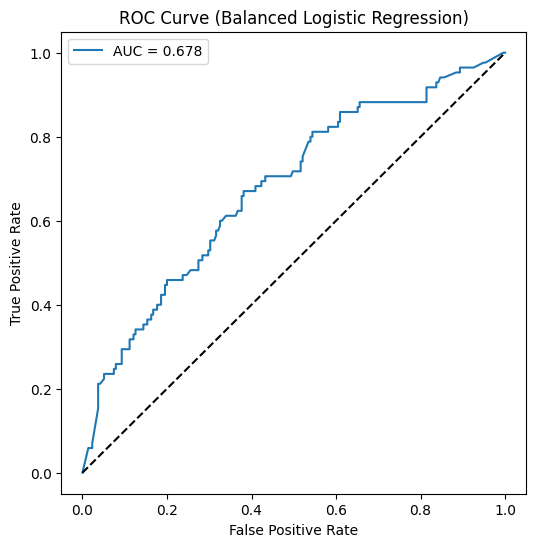

In [ ]:

# ROC Curve Plot
fpr, tpr, thresholds = roc_curve(y_test, y_prob_bal)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_bal:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Balanced Logistic Regression)")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve

In [ ]:
# ✅ Get precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_bal)


In [ ]:
thresholds = np.append(thresholds, 1)

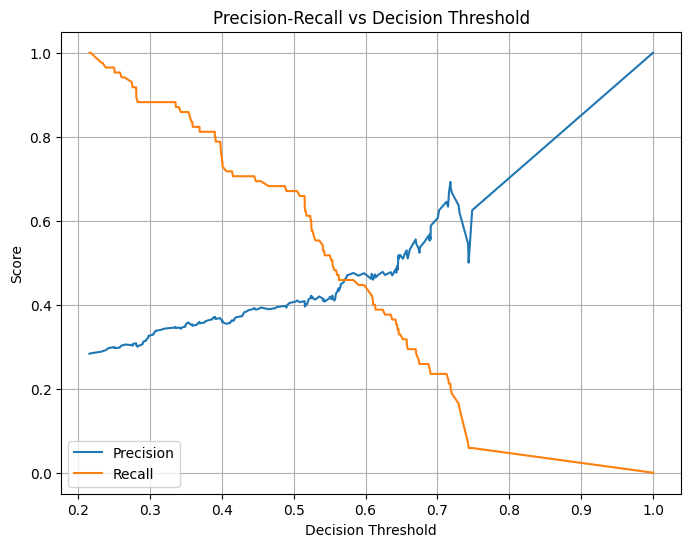

In [ ]:

# ✅ Plot Precision and Recall vs Threshold
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision, label="Precision")
plt.plot(thresholds, recall, label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Decision Threshold")
plt.legend()
plt.grid()
plt.show()


In [ ]:
threshold = 0.4
pred_custom = (y_prob_bal >= threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print(f"\nConfusion Matrix at threshold={threshold}:\n", confusion_matrix(y_test, pred_custom))
print("\nClassification Report:\n", classification_report(y_test, pred_custom))



Confusion Matrix at threshold=0.4:
 [[103 112]
 [ 22  63]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.48      0.61       215
           1       0.36      0.74      0.48        85

    accuracy                           0.55       300
   macro avg       0.59      0.61      0.55       300
weighted avg       0.69      0.55      0.57       300



In [ ]:
# ✅ Compute FPR, TPR
fpr, tpr, thresholds = roc_curve(y_test, y_prob_bal)

In [ ]:
# ✅ KS statistic
ks_statistic = max(tpr - fpr)
ks_threshold = thresholds[np.argmax(tpr - fpr)]


In [ ]:
print("KS Statistic:", ks_statistic)
print("Best Threshold (for KS):", ks_threshold)


KS Statistic: 0.28919288645690827
Best Threshold (for KS): 0.5048112418175754


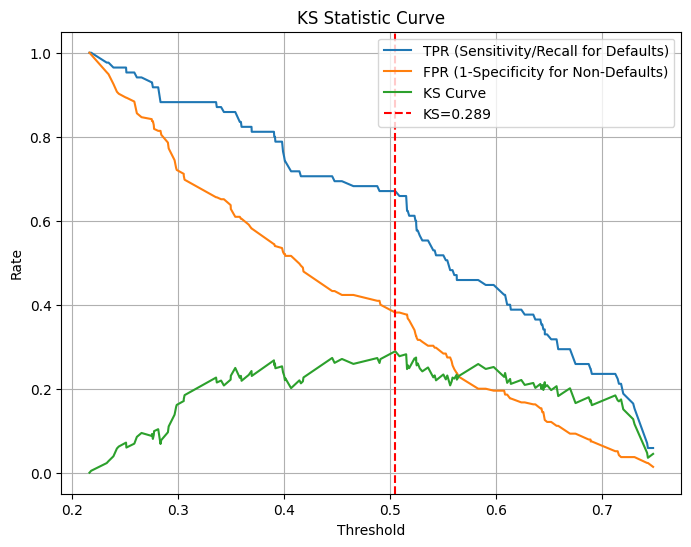

In [ ]:
#  Plot KS Curve
plt.figure(figsize=(8,6))
plt.plot(thresholds, tpr, label="TPR (Sensitivity/Recall for Defaults)")
plt.plot(thresholds, fpr, label="FPR (1-Specificity for Non-Defaults)")
plt.plot(thresholds, tpr - fpr, label="KS Curve")
plt.axvline(ks_threshold, color="r", linestyle="--", label=f"KS={ks_statistic:.3f}")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("KS Statistic Curve")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Define parameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced'],
    'l1_ratio': [0.5]  # Only used for elasticnet
}


In [ ]:
# Logistic Regression with more iterations
log_reg = LogisticRegression(max_iter=2000)

# GridSearchCV
grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='roc_auc',   # optimize for AUC
    cv=5,                # 5-fold cross-validation
    n_jobs=-1,           # use all cores
    verbose=2
)

# Define parameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced'],
    'l1_ratio': [0.5]  # Only used for elasticnet
}

# Logistic Regression with more iterations
log_reg = LogisticRegression(max_iter=2000)

# GridSearchCV
grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='roc_auc',   # optimize for AUC
    cv=5,                # 5-fold cross-validation
    n_jobs=-1,           # use all cores
    verbose=2
)

# Fit GridSearch
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best AUC Score (CV):", grid.best_score_)

# Evaluate best model on test set
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

print("\nTest ROC-AUC:", roc_auc_score(y_test, y_prob_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'C': 0.01, 'class_weight': None, 'l1_ratio': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}
Best AUC Score (CV): 0.6718727722772277

Test ROC-AUC: 0.6778385772913816

Confusion Matrix:
 [[207   8]
 [ 71  14]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.96      0.84       215
           1       0.64      0.16      0.26        85

    accuracy                           0.74       300
   macro avg       0.69      0.56      0.55       300
weighted avg       0.71      0.74      0.68       300



/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solve

In [ ]:
y_prob_best = best_model.predict_proba(X_test)[:, 1]
y_pred_best = (y_prob_best >= 0.5).astype(int)

print("===== BASE MODEL (Threshold=0.5) =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_best))
print("="*50, "\n")




===== BASE MODEL (Threshold=0.5) =====
Confusion Matrix:
 [[207   8]
 [ 71  14]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.96      0.84       215
           1       0.64      0.16      0.26        85

    accuracy                           0.74       300
   macro avg       0.69      0.56      0.55       300
weighted avg       0.71      0.74      0.68       300

ROC-AUC: 0.6778385772913816



In [ ]:
# ---------- OPTION 1: THRESHOLD TUNING ----------
threshold = 0.3  # you can try 0.25, 0.35 etc.
y_pred_thresh = (y_prob_best >= threshold).astype(int)

print("===== THRESHOLD TUNING (Threshold=0.3) =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))
print("\nClassification Report:\n", classification_report(y_test, y_pred_thresh))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_best))
print("="*50, "\n")


===== THRESHOLD TUNING (Threshold=0.3) =====
Confusion Matrix:
 [[ 85 130]
 [ 13  72]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.40      0.54       215
           1       0.36      0.85      0.50        85

    accuracy                           0.52       300
   macro avg       0.61      0.62      0.52       300
weighted avg       0.72      0.52      0.53       300

ROC-AUC: 0.6778385772913816



In [ ]:
# ---------- OPTION 2: CLASS WEIGHTS ----------
log_reg_bal = LogisticRegression(
    max_iter=2000,
    solver='liblinear',
    penalty='l2',
    C=0.01,
    class_weight='balanced'
)
log_reg_bal.fit(X_train, y_train)

y_prob_bal = log_reg_bal.predict_proba(X_test)[:, 1]
y_pred_bal = log_reg_bal.predict(X_test)

print("===== CLASS WEIGHTS (balanced) =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_bal))
print("="*50, "\n")


===== CLASS WEIGHTS (balanced) =====
Confusion Matrix:
 [[134  81]
 [ 31  54]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.62      0.71       215
           1       0.40      0.64      0.49        85

    accuracy                           0.63       300
   macro avg       0.61      0.63      0.60       300
weighted avg       0.70      0.63      0.64       300

ROC-AUC: 0.6784404924760601



In [ ]:

# ---------- OPTION 3: SMOTE ----------
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_res))

log_reg_smote = LogisticRegression(
    max_iter=2000,
    solver='liblinear',
    penalty='l2',
    C=0.01
)
log_reg_smote.fit(X_res, y_res)

y_prob_smote = log_reg_smote.predict_proba(X_test)[:, 1]
y_pred_smote = log_reg_smote.predict(X_test)

print("\n===== SMOTE (Oversampled Training Data) =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_smote))

Before SMOTE: [501 199]
After SMOTE: [501 501]

===== SMOTE (Oversampled Training Data) =====
Confusion Matrix:
 [[133  82]
 [ 30  55]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.62      0.70       215
           1       0.40      0.65      0.50        85

    accuracy                           0.63       300
   macro avg       0.61      0.63      0.60       300
weighted avg       0.70      0.63      0.64       300

ROC-AUC: 0.6787688098495211


In [ ]:
# Get predicted probabilities from your best model
y_prob_best = best_model.predict_proba(X_test)[:, 1]

# Compute FPR, TPR, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)

# KS statistic = max difference between TPR and FPR
ks_values = tpr - fpr
ks_stat = np.max(ks_values)
best_threshold = thresholds[np.argmax(ks_values)]

print("KS Statistic:", ks_stat)
print("Best Threshold (for KS):", best_threshold)

# Apply threshold
y_pred_ks = (y_prob_best >= best_threshold).astype(int)

print("\n===== MODEL WITH KS-OPTIMAL THRESHOLD =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ks))
print("\nClassification Report:\n", classification_report(y_test, y_pred_ks))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_best))

KS Statistic: 0.2793433652530779
Best Threshold (for KS): 0.3107640733467149

===== MODEL WITH KS-OPTIMAL THRESHOLD =====
Confusion Matrix:
 [[ 98 117]
 [ 15  70]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.46      0.60       215
           1       0.37      0.82      0.51        85

    accuracy                           0.56       300
   macro avg       0.62      0.64      0.56       300
weighted avg       0.73      0.56      0.57       300

ROC-AUC: 0.6778385772913816


KS Statistic: 0.2793433652530779
Best Threshold (for KS): 0.3107640733467149


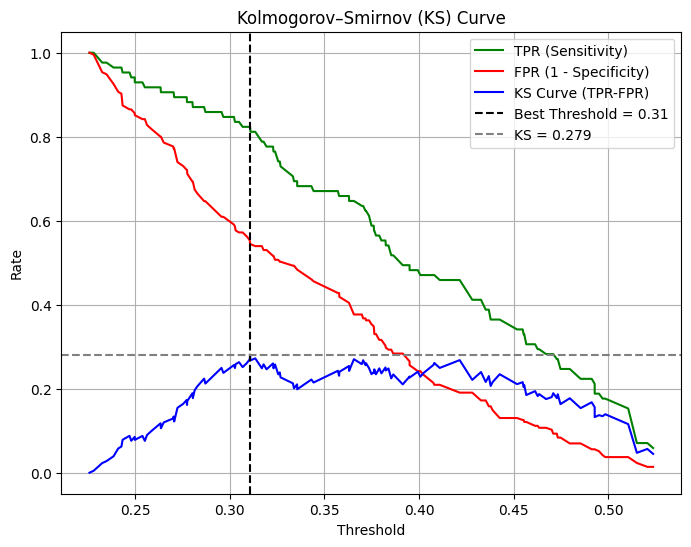

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Predicted probabilities for defaulters
y_prob_best = best_model.predict_proba(X_test)[:, 1]

# Compute FPR, TPR and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)

# KS values = difference between TPR and FPR
ks_values = tpr - fpr
ks_stat = np.max(ks_values)
best_threshold = thresholds[np.argmax(ks_values)]

print("KS Statistic:", ks_stat)
print("Best Threshold (for KS):", best_threshold)

# ---------- Plot KS Curve ----------
plt.figure(figsize=(8,6))

plt.plot(thresholds, tpr, label="TPR (Sensitivity)", color="green")
plt.plot(thresholds, fpr, label="FPR (1 - Specificity)", color="red")
plt.plot(thresholds, ks_values, label="KS Curve (TPR-FPR)", color="blue")

# Mark the best threshold point
plt.axvline(x=best_threshold, color="black", linestyle="--", label=f"Best Threshold = {best_threshold:.2f}")
plt.axhline(y=ks_stat, color="gray", linestyle="--", label=f"KS = {ks_stat:.3f}")

plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("Kolmogorov–Smirnov (KS) Curve")
plt.legend()
plt.grid(True)
plt.show()


Before SMOTE: [501 199]
After SMOTE: [501 501]
KS Statistic: 0.28262653898768814
Best Threshold (for KS): 0.45137138279916295

===== MODEL WITH KS-OPTIMAL THRESHOLD =====
Confusion Matrix:
 [[124  91]
 [ 25  60]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.58      0.68       215
           1       0.40      0.71      0.51        85

    accuracy                           0.61       300
   macro avg       0.61      0.64      0.59       300
weighted avg       0.71      0.61      0.63       300

ROC-AUC: 0.6805198358413133


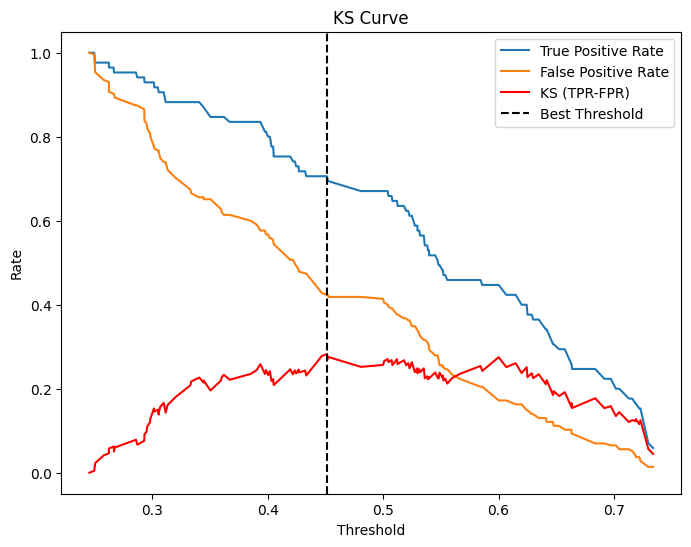

In [ ]:
# ==========================
# Credit Risk Scorecard Pipeline with SMOTE + KS
# ==========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from imblearn.over_sampling import SMOTE

# ------------------------
# 1. Load dataset
# ------------------------
# df = pd.read_csv("your_final_dataset.csv")  # replace with your file
target_col = "DEFAULT"
X = df.drop(columns=[target_col])
y = df[target_col]

# ------------------------
# 2. Train-test split
# ------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ------------------------
# 3. Apply SMOTE (to handle imbalance)
# ------------------------
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_res))

# ------------------------
# 4. Scale features
# ------------------------
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# ------------------------
# 5. Logistic Regression
# ------------------------
model = LogisticRegression(max_iter=500, solver="liblinear")
model.fit(X_train_res, y_train_res)

# ------------------------
# 6. Predict Probabilities
# ------------------------
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# ------------------------
# 7. Compute KS Statistic
# ------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

KS_values = tpr - fpr
KS_stat = np.max(KS_values)
best_threshold = thresholds[np.argmax(KS_values)]

print("KS Statistic:", KS_stat)
print("Best Threshold (for KS):", best_threshold)

# ------------------------
# 8. Apply KS-optimal threshold
# ------------------------
y_pred_ks = (y_prob >= best_threshold).astype(int)

print("\n===== MODEL WITH KS-OPTIMAL THRESHOLD =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ks))
print("\nClassification Report:\n", classification_report(y_test, y_pred_ks))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# ------------------------
# 9. Plot KS Curve
# ------------------------
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, label="True Positive Rate")
plt.plot(thresholds, fpr, label="False Positive Rate")
plt.plot(thresholds, KS_values, label="KS (TPR-FPR)", color="red")
plt.axvline(x=best_threshold, color="black", linestyle="--", label="Best Threshold")
plt.title("KS Curve")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.legend()
plt.show()


AUC: 0.6781121751025991
Gini: 0.35622435020519827
KS Statistic: 0.2801641586867305
Confusion Matrix:
 [[207   8]
 [ 67  18]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.96      0.85       215
           1       0.69      0.21      0.32        85

    accuracy                           0.75       300
   macro avg       0.72      0.59      0.59       300
weighted avg       0.74      0.75      0.70       300



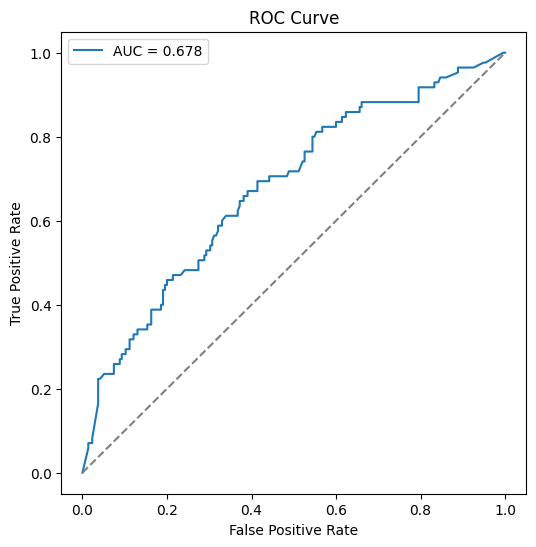

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load WOE transformed dataset
df = pd.read_csv("WOE_transformed.csv")

# Final 7 features (drop R_GROCERIES_DEBT)
final_features = [
    "R_DEBT_INCOME",
    "R_TAX_DEBT",
    "R_ENTERTAINMENT_DEBT",
    "R_HEALTH_DEBT",
    "R_TRAVEL_DEBT",
    "R_CLOTHING_DEBT",
    "R_DEBT_SAVINGS"
]

X = df[final_features]
y = df["DEFAULT"]

# Train-test split (70-30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Logistic Regression model
model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# --- Evaluation ---
# AUC
auc = roc_auc_score(y_test, y_prob)
print("AUC:", auc)
print("Gini:", 2*auc - 1)

# KS Statistic
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
ks = max(tpr - fpr)
print("KS Statistic:", ks)

# Confusion matrix & classification report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- ROC Curve Plot ---
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--', color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

threshold = 0.3  # try 0.25, 0.35 etc.
y_pred_thresh = (y_prob_best >= threshold).astype(int)

print("===== THRESHOLD TUNING (Threshold=0.3) =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))
print("\nClassification Report:\n", classification_report(y_test, y_pred_thresh))

roc_auc = roc_auc_score(y_test, y_prob_best)
gini = 2 * roc_auc - 1

print("ROC-AUC:", roc_auc)
print("GINI:", gini)
print("="*50, "\n")


===== THRESHOLD TUNING (Threshold=0.3) =====
Confusion Matrix:
 [[ 85 130]
 [ 13  72]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.40      0.54       215
           1       0.36      0.85      0.50        85

    accuracy                           0.52       300
   macro avg       0.61      0.62      0.52       300
weighted avg       0.72      0.52      0.53       300

ROC-AUC: 0.6778385772913816
GINI: 0.3556771545827633



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# ---------- BASE MODEL (Best from GridSearch) ----------
y_prob_best = best_model.predict_proba(X_test)[:, 1]
y_pred_best = (y_prob_best >= 0.5).astype(int)

print("===== BASE MODEL (Threshold=0.5) =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

roc_auc = roc_auc_score(y_test, y_prob_best)
gini = 2 * roc_auc - 1

print("ROC-AUC:", roc_auc)
print("GINI:", gini)
print("="*50, "\n")


===== BASE MODEL (Threshold=0.5) =====
Confusion Matrix:
 [[207   8]
 [ 71  14]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.96      0.84       215
           1       0.64      0.16      0.26        85

    accuracy                           0.74       300
   macro avg       0.69      0.56      0.55       300
weighted avg       0.71      0.74      0.68       300

ROC-AUC: 0.6778385772913816
GINI: 0.3556771545827633

